____

**Data:** In this section, we use data from the GitHub repository:    [link_git_JJAlmagro](https://github.com/JJAlmagro/subcellular_localization/tree/refs/heads/master/notebook%20tutorial/data/reduced_train.npz).

In the dataset, we have 2423 protein sequences (length : 400 amino acids) represented by a PSSM (Position-Specific Scoring Matrix). Each position is represented by a probability of being a particular amino acid.

**Goal:** Predict the subcellular localization of proteins based on the PSSM of the sequences. There are 10 possible localizations.

**Contact:** [stephanie.gnanalingam\@etu.u-paris.fr](mailto:stephanie.gnanalingam@etu.u-paris.fr)

____

# Import the packages

In [ ]:
# import and set important seeds
import os
os.environ['PYTHONHASHSEED']=str(42)
import random
random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
import numpy as np
np.random.seed(42)
# to download the data from Github
import requests
import zipfile
from tqdm import tqdm
# ploting the models and their performances
from tensorflow import keras
keras.utils.set_random_seed(42)
from keras.utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt
# stock the data
import pandas as pd
from pandas import read_csv
# format the data
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# create the models CNN and Resnet
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv1D, Flatten
from keras import Input, Model
from keras.layers import Activation
from keras.layers import Add
from keras.layers import AveragePooling1D, BatchNormalization, MaxPooling1D
from sklearn.utils import class_weight
from tensorflow.keras import optimizers
from keras.regularizers import l2
# for early stopping and saving of the best model
from tensorflow.keras import callbacks
# evaluate the model
import sklearn
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection  import KFold
# optimizing the model
from sklearn.model_selection import RandomizedSearchCV

2024-09-25 18:26:54.868697: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-25 18:26:54.870272: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-25 18:26:54.932327: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-25 18:26:55.183985: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 18:26:56.275132: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [ ]:
# relating scikit-learn and Keras
!pip install scikeras

In [ ]:
from scikeras.wrappers import KerasClassifier

# Download the data in Google drive

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd  /content/drive/MyDrive
# create a new folder entitled M2BI_DRIVE if it does not exists
%mkdir M2BI_DRIVE
# get into it and set it as the working directory
%cd  /content/drive/MyDrive/M2BI_DRIVE
%pwd

## Download step

In [ ]:
def download_data():
    """Download the data from the github link
    Parameters:
    -----------
    None

    Result:
    -------
    None, the data will be downloaded in the user's google drive
    """
    # url to the github page
    url="https://github.com/JJAlmagro/subcellular_localization/raw/refs/heads/master/notebook%20tutorial/data/reduced_train.npz"
    # the folder where the data is going to be stored
    datasetFolderPath = "dataset/"
    file = "reduced_train.npz"
    # indicate where we want to download the file
    FilePath = os.path.join(datasetFolderPath, file)

    if not os.path.exists(datasetFolderPath):
    # create the folder if it does not exists
        os.makedirs(datasetFolderPath)

    def download_file(url, filename):
        # send a HTTP request. The file will be downloaded in parts
        response = requests.get(url, stream=True)
        # display a progressing bar
        # write : the tqdm bar is related to the writing operation
        # miniters : update the bar after each iteration
        # desc : print the file name next to the progressing bar
        with tqdm.wrapattr(open(filename, "wb"), "write", miniters=1,
                           total=int(response.headers.get('content-length', 0)),
                           desc=filename) as fout:
            # the file is separated in chuncks of size 4096 byte
            for chunk in response.iter_content(chunk_size=4096):
                fout.write(chunk)

    if not os.path.exists(FilePath):
        download_file(url, FilePath)

In [ ]:
download_data()

dataset/reduced_train.npz: 100%|██████████| 8.52M/8.52M [00:01<00:00, 4.67MB/s]


# PRIOR ANALYSIS OF THE DATA

## Import the data

In [ ]:
file_data = "reduced_train.npz"

data_file = np.load(file_data)
X = data_file["X_train"]
Y = data_file["y_train"]

## Visualize the data

In [ ]:
print("Shape of dataset X:")
print(X.shape)
print("Shape of dataset Y:")
print(Y.shape)
print("First 5 rows of X:\n", X[:5])
print("First 5 elements of Y:\n", Y[:5])

Shape of dataset X:
(2423, 400, 20)
Shape of dataset Y:
(2423,)
First 5 rows of X:
 [[[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.48 0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.  

**We have 2423 protein sequences of length 400. For each of the positions, we have the probabilities of being an amino acid (in total, there are 20 of them). It explains the shape of X matrix. Y is a vector containg a number corresponding o the subcellular localization.**

# DATA TRANSFORMATION

In [ ]:
# In order to do a deep learning model, we need to encode the output result, Y.
# Here, we perform a one-hot encoding (OHE)
classes = LabelEncoder() # returns an instance of LabelEncoder in order to perform the OHE
classes.fit(Y) # returns an instance of LabelEncoder with the unique classes
classes_Y = classes.transform(Y) # transform the data to the classes generated before
onehot_Y = to_categorical(classes_Y) # performs the OHE (example : class 0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
# check the output of OHE
print("First 5 rows of one-hot encoded Y:\n", onehot_Y[:5])

First 5 rows of one-hot encoded Y:
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


The OHE seems to have worked well.

# DATA ANALYSIS

**Analysis of the first amino acid probabilities (the first feature) at the first position for all the 2423 sequences:**

In [ ]:
# Example: Statistics for the first feature across all samples and time points
df_X = pd.DataFrame(X[:, :, 0])  # Analyze the first feature (index 0 in the third dimension)
stats_first_feature = df_X.describe()
print(stats_first_feature)

               0            1            2            3            4    \
count  2423.000000  2423.000000  2423.000000  2423.000000  2423.000000   
mean      0.021865     0.205510     0.099270     0.075233     0.088902   
std       0.114766     0.298015     0.175479     0.142319     0.156583   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.050000     0.020000     0.020000     0.030000   
75%       0.000000     0.300000     0.120000     0.090000     0.100000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               5            6            7            8            9    ...  \
count  2423.000000  2423.000000  2423.000000  2423.000000  2423.000000  ...   
mean      0.085184     0.093553     0.089930     0.100896     0.099030  ...   
std       0.145490     0.159008     0.150393     0.156734     0.152685  ...   
min       0.00000

**Interpretation:**

For each position (400) of our sequences (2423) we have a summary of being an amino acid. It seems that this amino acid is not present a lot at the first position of the sequences because the mean is low. However, there are sequences for which we have this amino acid with the probability of 1.

**We are going to see if there are any positions that are correlated and so, briniging the same information. For further analysis, it can be good to delete them to avoid redundancy:**

In [ ]:
"""
X_flattened = X.reshape(2423, 400 * 20) # reshaping the data in order to apply corr
df_X_flattened = pd.DataFrame(X_flattened)
df_corr = df_X_flattened.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(df_corr, annot=True, cmap='Blues')
plt.tight_layout()
"""

This step is too long so it hadn't been executed.

**The classes distribution:**

Text(0.5, 0, 'Classes')

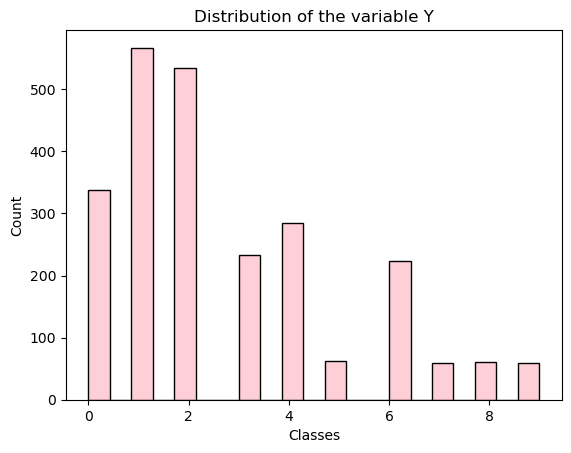

In [ ]:
sns.histplot(Y, color="pink", edgecolor="black")
plt.title("Distribution of the variable Y")
plt.xlabel("Classes")

**Interpretation:**

We have an unbalanced data set. We need to adjust the classes weights in order to have a balanced learning of all the classes. Otherwise, the classes with minimal data will be ignored during the learning process.

In [ ]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(Y),
                                        y = Y
                                    )
class_weights = dict(enumerate(class_weights))
print(f'Class Weights: {class_weights}\n')

Class Weights: {0: 0.7168639053254438, 1: 0.427336860670194, 2: 0.45289719626168223, 3: 1.0399141630901287, 4: 0.8501754385964913, 5: 3.846031746031746, 6: 1.0816964285714286, 7: 4.106779661016949, 8: 4.038333333333333, 9: 4.106779661016949}



**Interpretation:**

The classes with minimum data have a more important weight.

# CALLBACK STRATEGY

**The more the number of epoch is high and the more we have a risk of overfitting. In order to avoid that, we will have an option to stop the training if the accuracy on the validation set doesn't improve significantly.**

In [ ]:
callback = callbacks.EarlyStopping(monitor='val_weighted_accuracy', patience=10, mode='max')
# we measure the weighted accuracy because we have unbalanced data.

**As the epoch increases, the performances can change. That's why it is important to save the best model all along the training.**

In [ ]:
model_checkpoint = callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True)

# DATA PARTITIONING

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, onehot_Y, test_size=0.2, random_state=3, shuffle=True)

In [ ]:
print("Shape of dataset X:")
print(X.shape)
print("Shape of dataset X_train:")
print(X_train.shape)
print("Shape of dataset y_train:")
print(y_train.shape)
print("Shape of dataset X_test:")
print(X_test.shape)
print("Shape of dataset y_test:")
print(y_test.shape)

Shape of dataset X:
(2423, 400, 20)
Shape of dataset X_train:
(1938, 400, 20)
Shape of dataset y_train:
(1938, 10)
Shape of dataset X_test:
(485, 400, 20)
Shape of dataset y_test:
(485, 10)


Shapes are coherent.

# MODEL 1 : CNN (convolutional neural network)

## Create the model

In [ ]:
def simple_cnn():
    """Create a CNN.
    Parameters:
    -----------
    None

    Returns:
    model : Sequential
    """
    # sequential means directed in an unique direction
    model = Sequential()
    # add a convolutional layer with 64 filters (chosen randomly) as a result of each sequence PSSM
    # modification with a kernel of size 3. The activation function is relu to enable
    # non-linearity
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=42), bias_initializer=tf.keras.initializers.Zeros(), input_shape=(400, 20)))
    # in the next steps, we have convolutional layers with filter sizes which decreases
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=42), bias_initializer=tf.keras.initializers.Zeros()))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=42), bias_initializer=tf.keras.initializers.Zeros()))
    # finally we flatten the data (sequence length * filter) in order to get a vector to give as input of the Dense layer of probabilities result
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])
    return model

This model had been choosen because the data is complex. Having several convolutionnal layers can help for the training process.

## Summarize the model

In [ ]:
cnn_model = simple_cnn()
print(f'{cnn_model.summary()}')

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 398, 64)        │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 396, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 394, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 394, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12608)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │       126,090 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,274 (544.04 KB)

 Trainable params: 139,274 (544.04 KB)

 Non-trainable params: 0 (0.00 B)

None


**Interpretation:**

conv1d_6 : 20 (number of features) * 64 (number of filters) * 3 (kernel size) + 64 (bias) = 3904

conv1d_7 : 64 (input shape) * 32 (number of filters) * 3 (kernel size) + 32 = 6176

dense_2 : 6304 (input shape) * 10 (output shape) + 10 (bias) = 63050

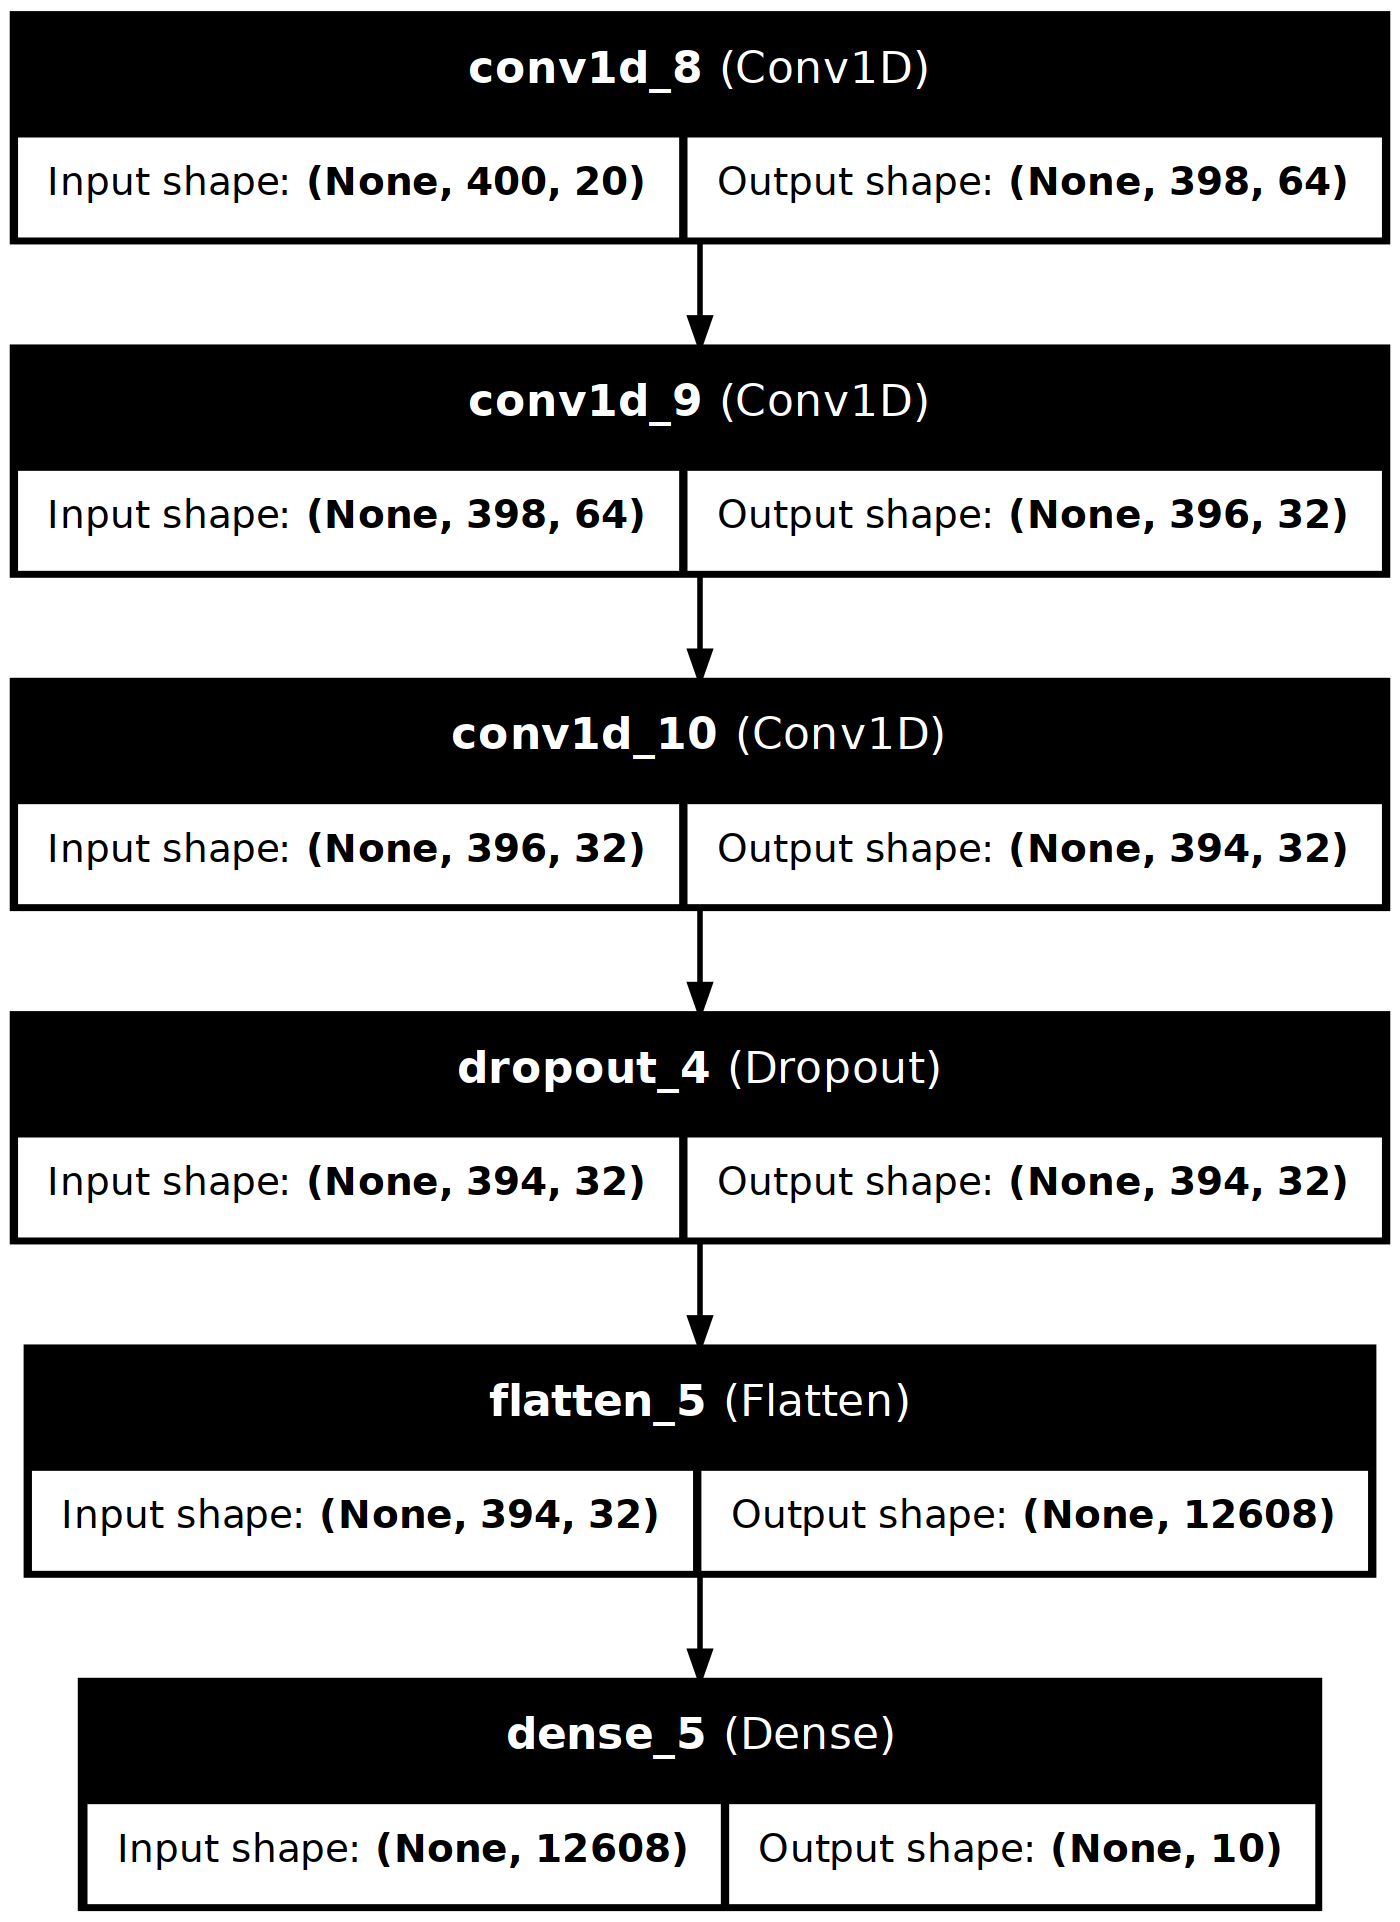

In [ ]:
plot_model(cnn_model, to_file="model_cnn.png", show_shapes=True, show_layer_names=True)

## Training

In [ ]:
cnn_history = cnn_model.fit(X_train, y_train, validation_split=0.2, epochs=15, batch_size=60, class_weight=class_weights, callbacks=[callback, model_checkpoint], shuffle=False)

Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1521 - loss: 2.3374 - weighted_accuracy: 0.1639 - val_accuracy: 0.2835 - val_loss: 2.1126 - val_weighted_accuracy: 0.2835
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3466 - loss: 1.9590 - weighted_accuracy: 0.4287 - val_accuracy: 0.3376 - val_loss: 1.9376 - val_weighted_accuracy: 0.3376
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4725 - loss: 1.6618 - weighted_accuracy: 0.5603 - val_accuracy: 0.4304 - val_loss: 1.7754 - val_weighted_accuracy: 0.4304
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6045 - loss: 1.3705 - weighted_accuracy: 0.6582 - val_accuracy: 0.5438 - val_loss: 1.6149 - val_weighted_accuracy: 0.5438
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7390 - loss: 1.1311 - weighted_accuracy: 0.7955 - val_accuracy: 0.6108 - val_loss: 1.4435 - val_weighted_accuracy: 0.6108
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7825 

**Interpretation:**

It is coherent to have an accuracy that increases and a loss that decreases for the train and test sets.

## Performance

In [ ]:
def plot_performances(m_history):
  """
  Plot the performances of a model.

  Parameters:
  -----------
  History object

  Returns:
  --------
  None
  """
  plt.plot(m_history.history['weighted_accuracy'])
  plt.plot(m_history.history['val_weighted_accuracy'])
  plt.title('Model weighted accuracy')
  plt.ylabel('Weighted ccuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

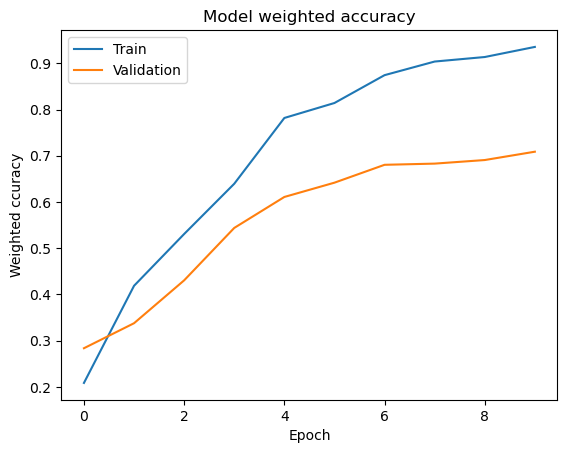

In [ ]:
plot_performances(cnn_history)

**Interpretation:**

The training is good. However, we have overfitting.

## Evaluating the performance on test data

In [ ]:
cnn_model.evaluate(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6766 - loss: 1.0143 - weighted_accuracy: 0.6766 


[1.0118176937103271,
 0.6783505082130432,
 0.6783505082130432,
 0.6783505082130432]

**Interpretation:**

We have the loss, accuracy and weighted accuracy for the test set. The accuracy is good but is not fantastic.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Text(0.5, 1.0, 'Confusion matrix of the predicted vs true localization')

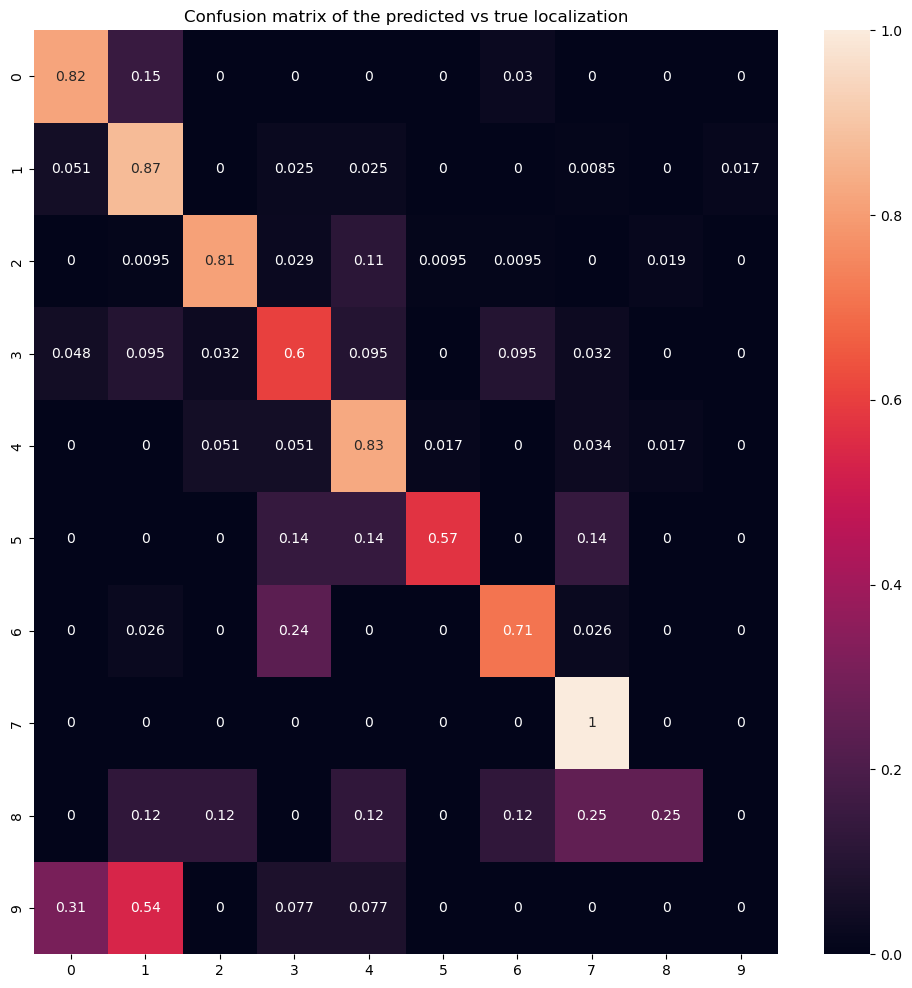

In [ ]:
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true_classes = np.argmax(y_test, axis = 1)
fig = plt.figure(figsize=(12, 12))
sns.heatmap(sklearn.metrics.confusion_matrix(y_true_classes, y_pred_classes, normalize="true"), annot=True)
plt.title("Confusion matrix of the predicted vs true localization")

**Interpretation:**

In the confusion matrix, we get the information of how the percentage of good predictions for each class. The 8 and 9th classes seem more complicated to predict. For the other class, it is fine.

## ROC curve et precision-recall curve

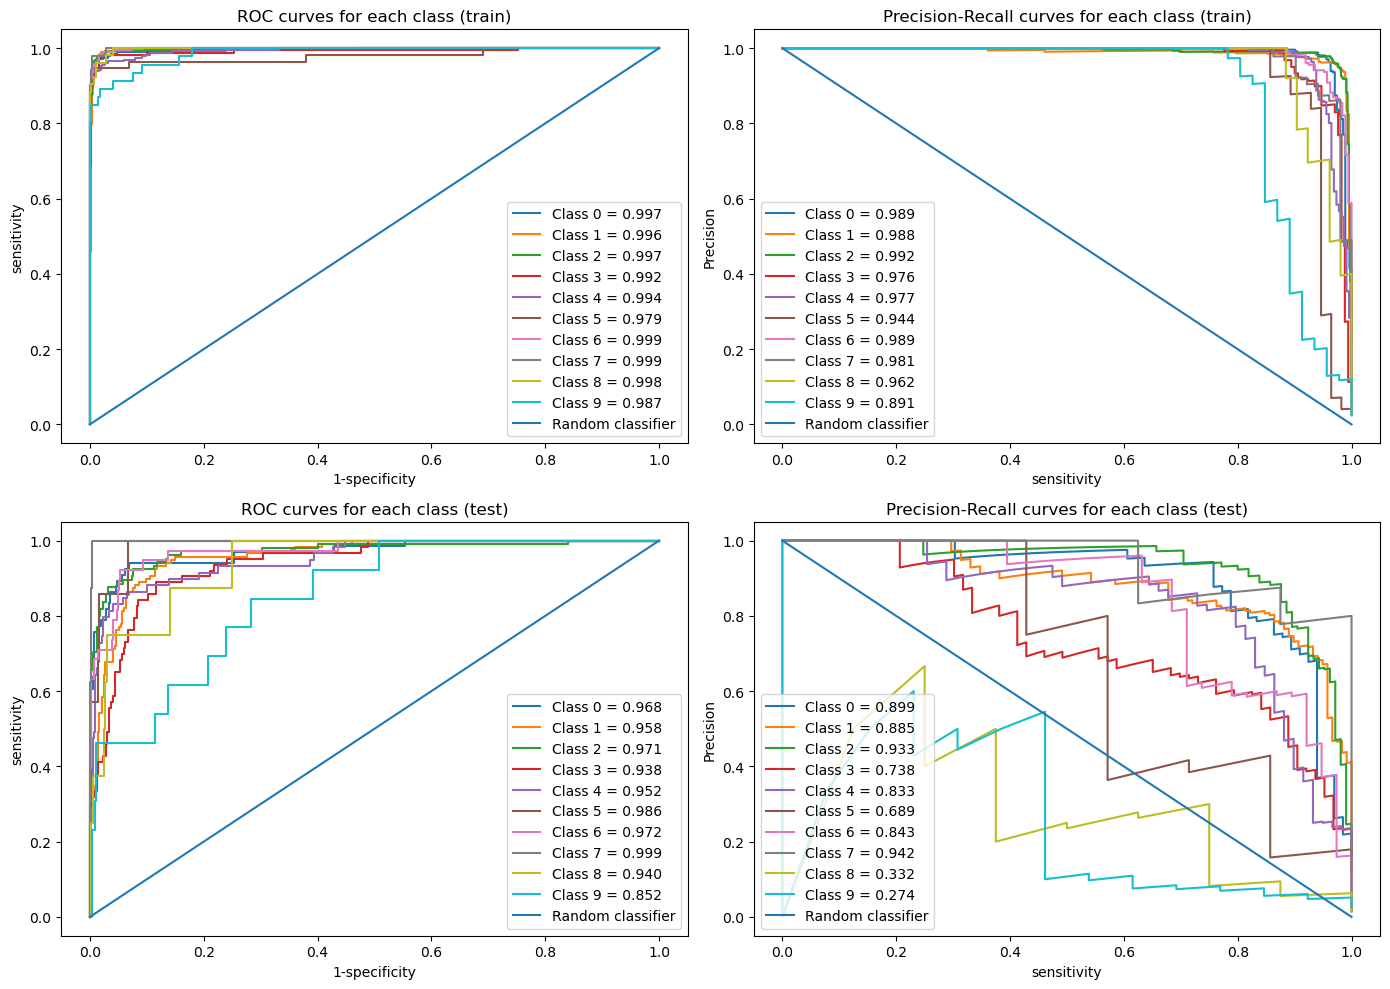

In [ ]:
# setting the axis for the final plot
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize = (14,10))
n_classes = 10

for i in range(n_classes):
    # we take the i-th class as the true labels
    # the only sequences with the label 1 will be that of the class i
    # the others will be at 0
    y_train_true = y_train[:, i]
    y_test_true = y_test[:, i]

    # calculate the predicted classes for train et test sets
    # we take the i-th class predictions
    train_pred = cnn_model.predict(X_train, verbose=0)[:, i]
    test_pred = cnn_model.predict(X_test, verbose=0)[:, i]

    # roc_curve enables to set thresholds and calculate FPR and TPR
    train_fpr, train_tpr, _ = roc_curve(y_train_true, train_pred)
    test_fpr, test_tpr, _ = roc_curve(y_test_true, test_pred)

    # calculate the area under the ROC curve
    auc_train = sklearn.metrics.auc(train_fpr, train_tpr)
    auc_test = sklearn.metrics.auc(test_fpr, test_tpr)

    ax1.plot(train_fpr, train_tpr, label=f"Class {i} = {auc_train:.3f}")
    ax3.plot(test_fpr, test_tpr, label=f"Class {i} = {auc_test:.3f}")

    # procede the same for precision-recall
    train_precision, train_recall, _ = precision_recall_curve(y_train_true, train_pred)
    test_precision, test_recall, _ = precision_recall_curve(y_test_true, test_pred)

    aupr_train = sklearn.metrics.average_precision_score(y_train_true, train_pred)
    aupr_test = sklearn.metrics.average_precision_score(y_test_true, test_pred)

    ax2.plot(train_recall, train_precision, label=f"Class {i} = {aupr_train:.3f}")
    ax4.plot(test_recall, test_precision, label=f"Class {i} = {aupr_test:.3f}")

# plot the random classifier for comparison
ax1.plot([0, 1], [0, 1], label='Random classifier')
ax1.set_xlabel('1-specificity')
ax1.set_ylabel('sensitivity')
ax1.set_title('ROC curves for each class (train)')
ax3.plot([0, 1], [0, 1], label='Random classifier')
ax3.set_xlabel('1-specificity')
ax3.set_ylabel('sensitivity')
ax3.set_title('ROC curves for each class (test)')

ax2.plot([0, 1], [1, 0], label='Random classifier')
ax2.set_xlabel('sensitivity')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall curves for each class (train)')
ax4.plot([0, 1], [1, 0], label='Random classifier')
ax4.set_xlabel('sensitivity')
ax4.set_ylabel('Precision')
ax4.set_title('Precision-Recall curves for each class (test)')

# to separate correctly each sub-graph
plt.tight_layout()
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()


**Interpretation:**

We can have the same conclusion as for the heatmap.

In [ ]:
# cross-validation
training = KerasClassifier(build_fn=simple_cnn, epochs=15, batch_size=60,verbose=0)
kfold = KFold(n_splits=5, shuffle=True)
cv_results = cross_val_score(training, X_train, y_train, cv=kfold)
print("Cross validation accuracies:", cv_results)
print("Results Cross validation : %.2f%% (%.2f%%)"%(cv_results.mean()*100, cv_results.std()*100))

/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/pyth

Cross validation accuracies: [0.75515464 0.65979381 0.75773196 0.76744186 0.74160207]
Results Cross validation : 73.63% (3.92%)


**Interpretation:**
Our first model predicts well. We are going to see if it's possible to improve the performances.

## Optimizing the parameters : model 1

In [ ]:
def simple_cnn_opt(learning_rate=0.001):
    """Create a CNN.
    Parameters:
    -----------
    learning_rate : float, modified by RandomizedSearchCV

    Returns:
    model : Sequential
    """
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=42),
                    bias_initializer=tf.keras.initializers.Zeros(), input_shape=(400, 20)))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=42),
                    bias_initializer=tf.keras.initializers.Zeros()))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=42),
                    bias_initializer=tf.keras.initializers.Zeros()))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])
    return model

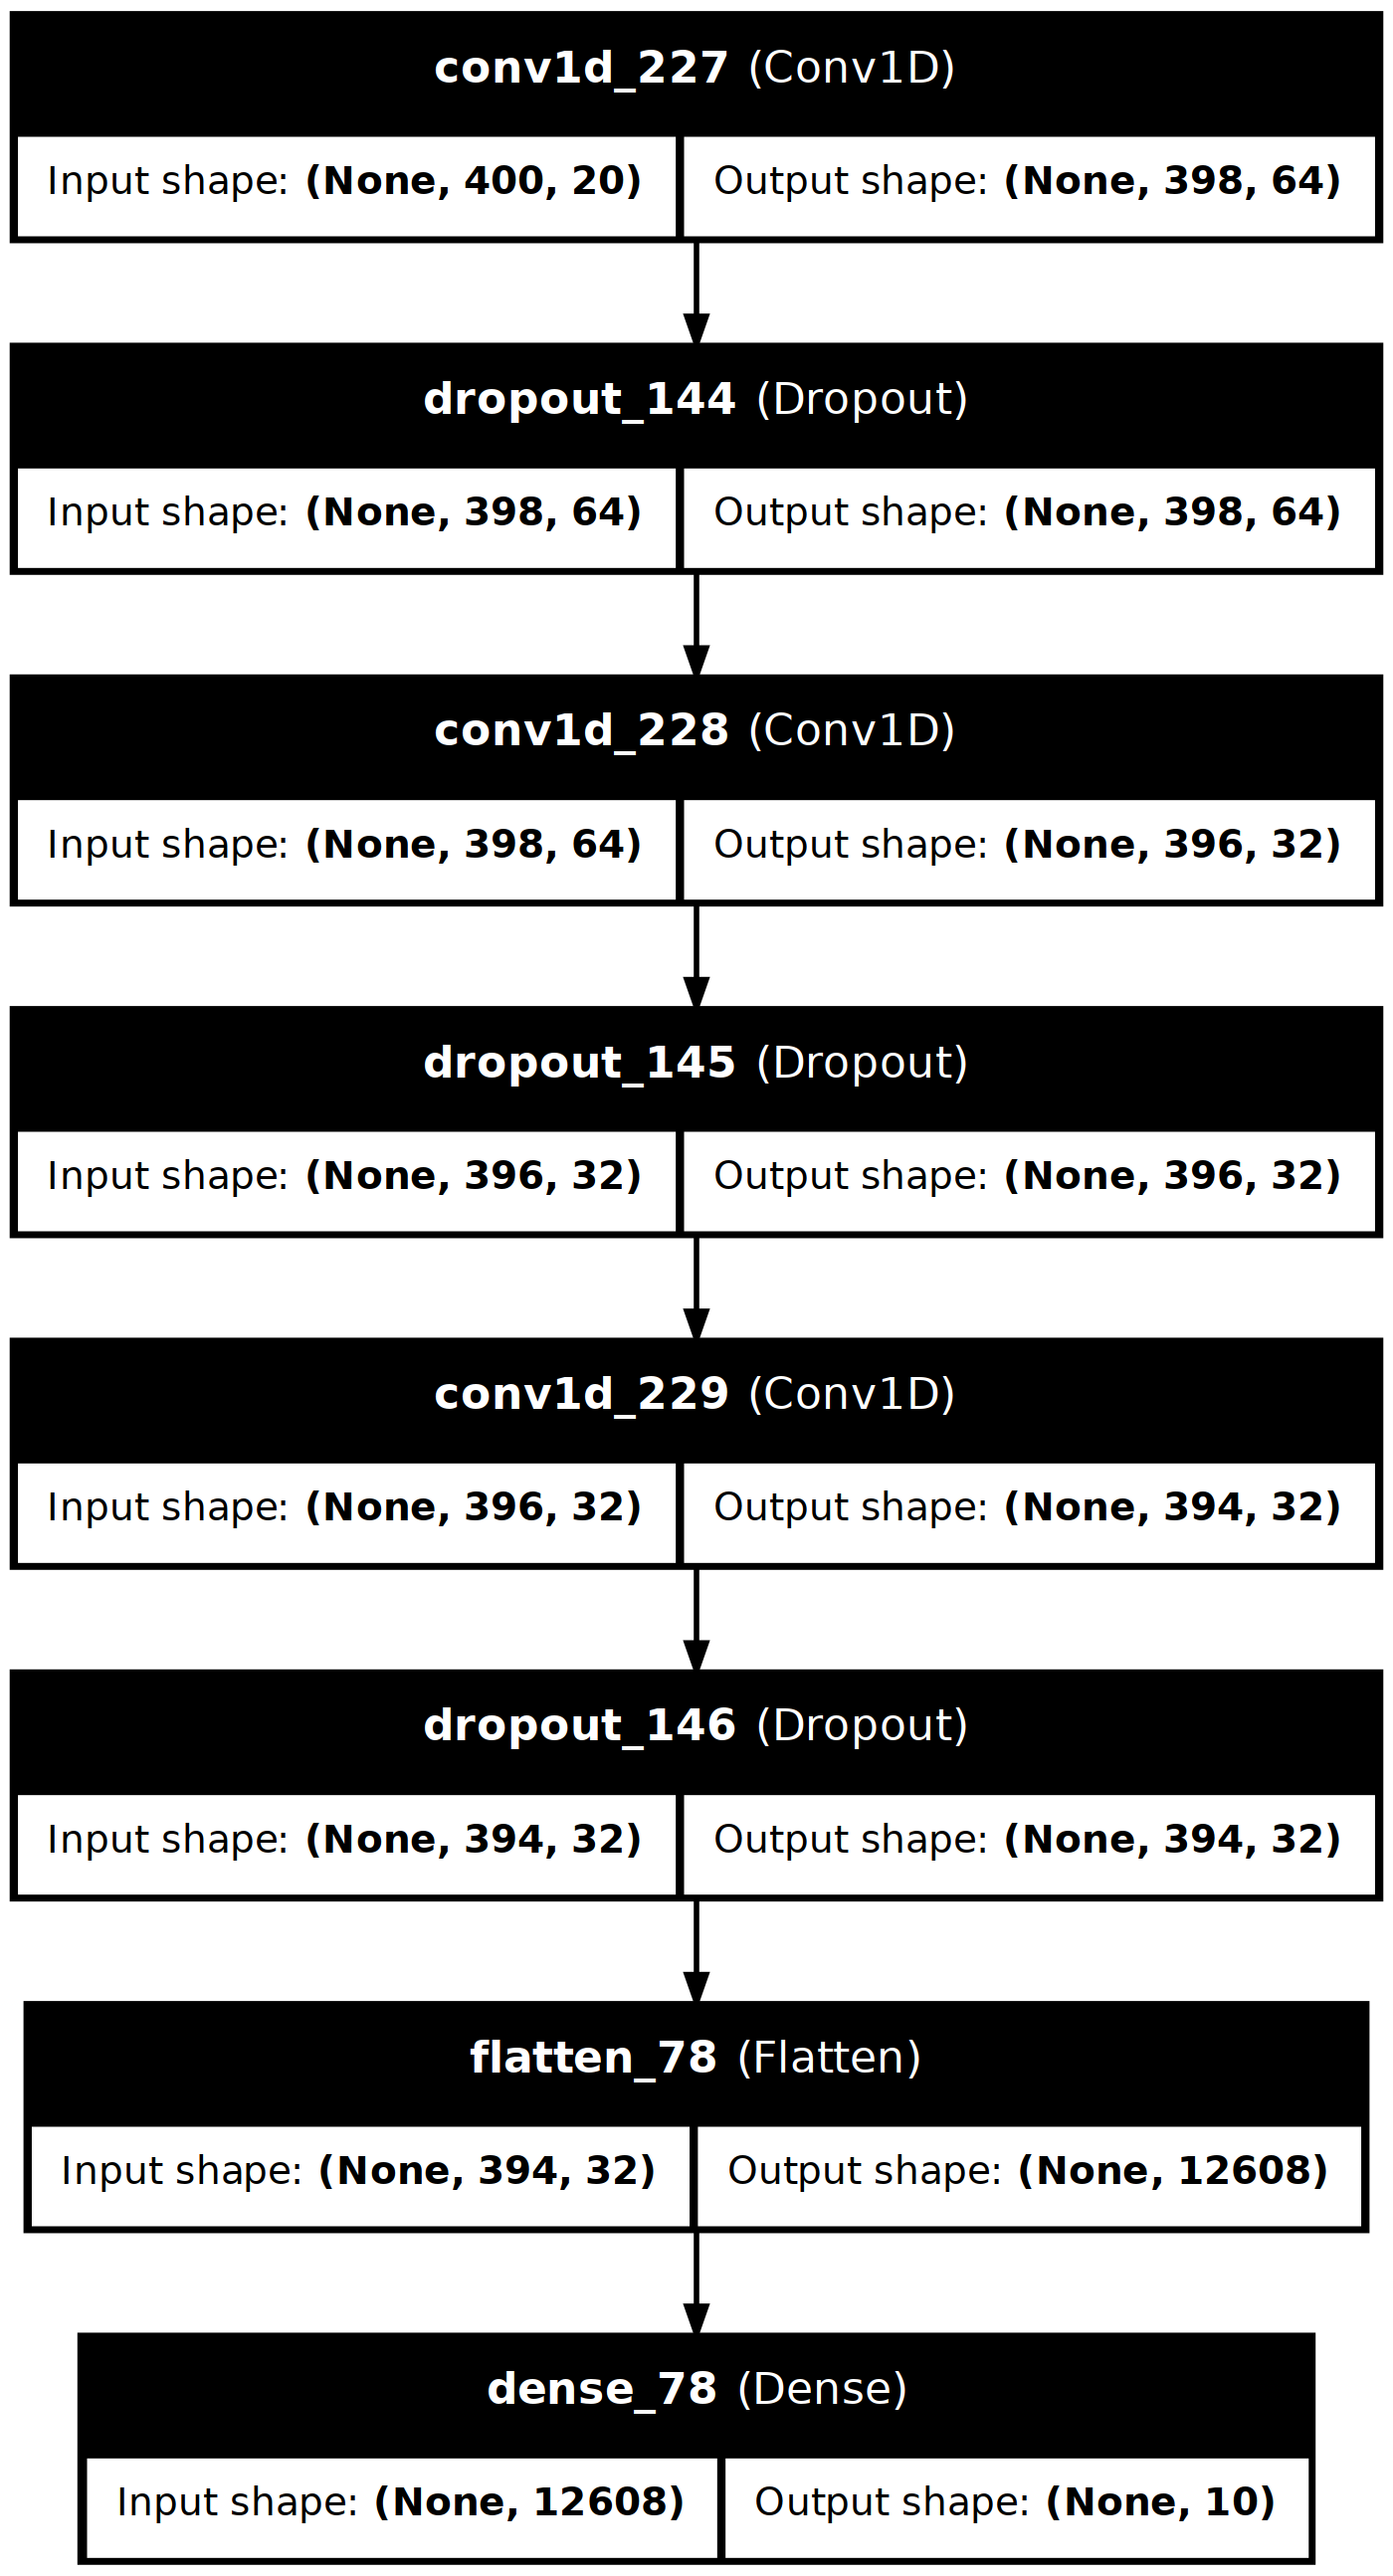

In [ ]:
cnn_model = simple_cnn_opt()
plot_model(cnn_model, to_file="model_cnn_opt.png", show_shapes=True, show_layer_names=True)

## RandomizedSearchCV

In [ ]:
# parameters that we are going to test
params = {
    'learning_rate': [0.000001, 0.00001, 0.0001, 0.001],
    'batch_size': [40, 50, 60, 70, 80, 90, 100],
    'epochs': [10, 15, 20, 25, 30, 35],
    'validation_split': [0.2]
}

# creating a keras classifier with our model to optimize and a default learning_rate value
classifier = KerasClassifier(build_fn=simple_cnn_opt, learning_rate=0.000001, verbose=0)
# f1-micro is adapted to multiple class prediction, cross validation value and the number of iteration was chosen randomly
model = RandomizedSearchCV(classifier, param_distributions=params, scoring='f1_micro', cv=3, random_state=42, return_train_score=True, n_iter=15)
grid = model.fit(X_train, y_train, callbacks = [callback, model_checkpoint], class_weight=class_weights)

/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/pyth

In [ ]:
# creating a pandas dataframe with the grid result
df_grid = pd.DataFrame(grid.cv_results_)
df_grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_validation_split,param_learning_rate,param_epochs,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,23.171979,2.616581,0.359495,0.064427,0.2,0.000010,30,90,"{'validation_split': 0.2, 'learning_rate': 1e-...",0.244582,0.174923,0.210526,0.210010,0.028441,7,0.273220,0.215944,0.212848,0.234004,0.027758
1,12.221383,0.485110,0.330944,0.069622,0.2,0.000100,15,50,"{'validation_split': 0.2, 'learning_rate': 0.0...",0.419505,0.391641,0.445820,0.418989,0.022122,5,0.571981,0.589783,0.613003,0.591589,0.016796
2,27.557857,2.623115,0.341334,0.033223,0.2,0.001000,35,80,"{'validation_split': 0.2, 'learning_rate': 0.0...",0.710526,0.738390,0.730650,0.726522,0.011744,1,0.937307,0.945046,0.941176,0.941176,0.003160
3,12.676550,0.349203,0.315916,0.022385,0.2,0.000010,15,50,"{'validation_split': 0.2, 'learning_rate': 1e-...",0.218266,0.150155,0.187307,0.185243,0.027845,11,0.231424,0.202786,0.198142,0.210784,0.014717
4,25.752246,0.583179,0.321937,0.043018,0.2,0.000100,35,90,"{'validation_split': 0.2, 'learning_rate': 0.0...",0.630031,0.620743,0.674923,0.641899,0.023657,4,0.819659,0.834365,0.844427,0.832817,0.010170
5,21.181931,0.550334,0.305572,0.014781,0.2,0.000010,30,100,"{'validation_split': 0.2, 'learning_rate': 1e-...",0.266254,0.153251,0.188854,0.202786,0.047173,9,0.278638,0.199690,0.198142,0.225490,0.037586
6,26.996888,1.592976,0.330077,0.024257,0.2,0.000001,35,100,"{'validation_split': 0.2, 'learning_rate': 1e-...",0.117647,0.058824,0.047988,0.074819,0.030605,15,0.109133,0.072755,0.048762,0.076883,0.024819
7,8.141129,0.176875,0.290562,0.005010,0.2,0.001000,10,60,"{'validation_split': 0.2, 'learning_rate': 0.0...",0.668731,0.726006,0.721362,0.705366,0.025975,3,0.930341,0.923375,0.935759,0.929825,0.005069
8,14.555981,0.296111,0.289763,0.004198,0.2,0.000010,20,80,"{'validation_split': 0.2, 'learning_rate': 1e-...",0.201238,0.151703,0.224458,0.192466,0.030343,10,0.198142,0.198916,0.210526,0.202528,0.005664
9,17.602604,0.098460,0.293426,0.015110,0.2,0.000001,25,60,"{'validation_split': 0.2, 'learning_rate': 1e-...",0.137771,0.041796,0.111455,0.097007,0.040492,13,0.157895,0.062693,0.115325,0.111971,0.038938


In [ ]:
df_grid.to_csv("model_grid.csv", index=False) # saving the grid

In [ ]:
model.best_params_ # checking out the parameters of the best model

{'validation_split': 0.2,
 'learning_rate': 0.001,
 'epochs': 35,
 'batch_size': 80}

Text(0.5, 1.0, 'Confusion matrix of the predicted vs true localization')

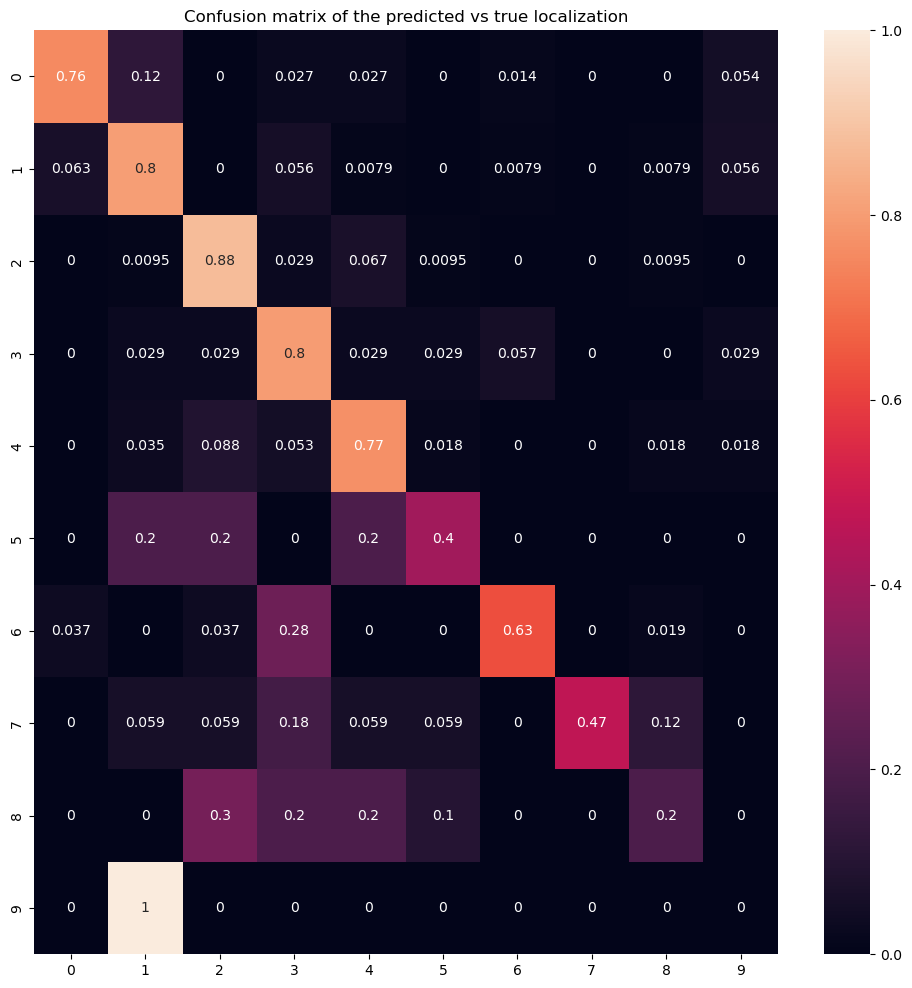

In [ ]:
# confusion matrix of the true labels and the preidcted labels by the best model
y_pred = model.best_estimator_.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true_classes = np.argmax(y_test, axis = 1)
fig = plt.figure(figsize=(12, 12))
sns.heatmap(sklearn.metrics.confusion_matrix(y_pred_classes, y_true_classes, normalize="true"), annot=True)
plt.title("Confusion matrix of the predicted vs true localization")

Epoch 1/35


/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.1250 - loss: 2.3396 - weighted_accuracy: 0.1542 - val_accuracy: 0.2990 - val_loss: 2.0354 - val_weighted_accuracy: 0.2990
Epoch 2/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3578 - loss: 1.7691 - weighted_accuracy: 0.4512 - val_accuracy: 0.4356 - val_loss: 1.6986 - val_weighted_accuracy: 0.4356
Epoch 3/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6364 - loss: 1.1478 - weighted_accuracy: 0.7068 - val_accuracy: 0.6237 - val_loss: 1.2565 - val_weighted_accuracy: 0.6237
Epoch 4/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7912 - loss: 0.6789 - weighted_accuracy: 0.8221 - val_accuracy: 0.6443 - val_loss: 1.1411 - val_weighted_accuracy: 0.6443
Epoch 5/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8434 - loss: 0.4498 - weighted_accuracy: 0.8784 - val_accuracy: 0.6856 - val_loss: 0.9614 - val_weighted_accuracy: 0.6856
Epoch 6/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8815 - loss

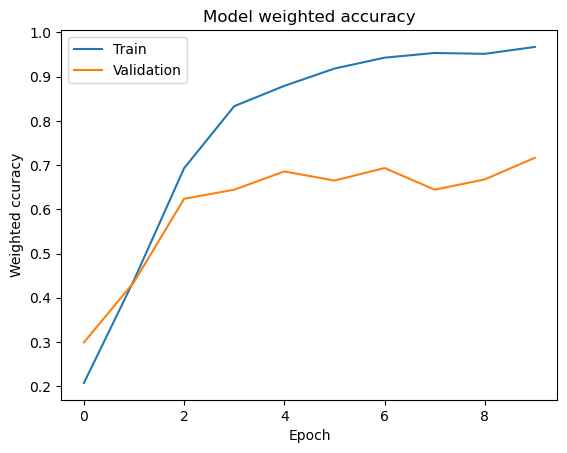

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7269 - loss: 0.8358 - weighted_accuracy: 0.7269


[0.7968751788139343,
 0.7402061820030212,
 0.7402061820030212,
 0.7402061820030212]

In [ ]:
# fiting the model again with the change of parameters
cnn_model = simple_cnn()
cnn_history = cnn_model.fit(X_train, y_train, validation_split=0.2, epochs=35, batch_size=80, class_weight=class_weights, callbacks=[callback, model_checkpoint], shuffle=False)
plot_performances(cnn_history)
cnn_model.evaluate(X_test, y_test)

In [ ]:
# cross-validation
training = KerasClassifier(build_fn=simple_cnn_opt, learning_rate=0.001, epochs=35, batch_size=80,verbose=0)
kfold = KFold(n_splits=5, shuffle=True)
cv_results = cross_val_score(training, X_train, y_train, cv=kfold)
print("Cross validation accuracies:", cv_results)
print("Results Cross validation : %.2f%% (%.2f%%)"%(cv_results.mean()*100, cv_results.std()*100))

/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/pyth

Cross validation accuracies: [0.72680412 0.73195876 0.75773196 0.74935401 0.77260982]
Results Cross validation : 74.77% (1.68%)


**Interpretation:**

This model is slightly better than the previous one.

# Optimizing the parameters : model 2

We are going to change the number of layers.

In [ ]:
def simple_cnn_opt_1(learning_rate=0.001):
    """Create a CNN.
    Parameters:
    -----------
    learning_rate : float, modified by RandomizedSearchCV

    Returns:
    model : Sequential
    """
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=42),
                    bias_initializer=tf.keras.initializers.Zeros(), kernel_regularizer=l2(0.000001), input_shape=(400, 20)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])
    return model

plot_model(simple_cnn_opt_1(0.01), to_file="model_cnn_opt_1.png", show_shapes=True, show_layer_names=True)

params = {
    'learning_rate': [0.000001, 0.00001, 0.0001, 0.001],
    'batch_size': [40, 50, 60, 70, 80, 90, 100],
    'epochs': [10, 15, 20, 25, 30, 35],
    'validation_split': [0.2]
}

classifier = KerasClassifier(build_fn=simple_cnn_opt_1, learning_rate=0.000001, verbose=0)
model = RandomizedSearchCV(classifier, param_distributions=params, scoring='f1_micro', cv=3, random_state=42, return_train_score=True, n_iter=15)
grid = model.fit(X_train, y_train, callbacks = [callback, model_checkpoint], class_weight=class_weights)


/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/pyth

In [ ]:
model.best_params_

{'validation_split': 0.2,
 'learning_rate': 0.001,
 'epochs': 35,
 'batch_size': 80}

Epoch 1/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 526ms/step - accuracy: 0.1475 - loss: 2.3837 - weighted_accuracy: 0.1724 - val_accuracy: 0.3196 - val_loss: 2.0749 - val_weighted_accuracy: 0.3196
Epoch 2/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 797ms/step - accuracy: 0.4307 - loss: 1.7766 - weighted_accuracy: 0.5323 - val_accuracy: 0.4124 - val_loss: 1.8421 - val_weighted_accuracy: 0.4124
Epoch 3/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.6498 - loss: 1.3956 - weighted_accuracy: 0.7056 - val_accuracy: 0.5696 - val_loss: 1.6230 - val_weighted_accuracy: 0.5696
Epoch 4/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.8003 - loss: 1.0543 - weighted_accuracy: 0.8372 - val_accuracy: 0.6340 - val_loss: 1.4285 - val_weighted_accuracy: 0.6340
Epoch 5/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.8579 - loss: 0.8157 - weighted_accuracy: 0.8843 - val_accuracy: 0.6649 - val_loss: 1.2690 - val_weighted_accuracy: 0.6649
Epoch 6/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step - accu

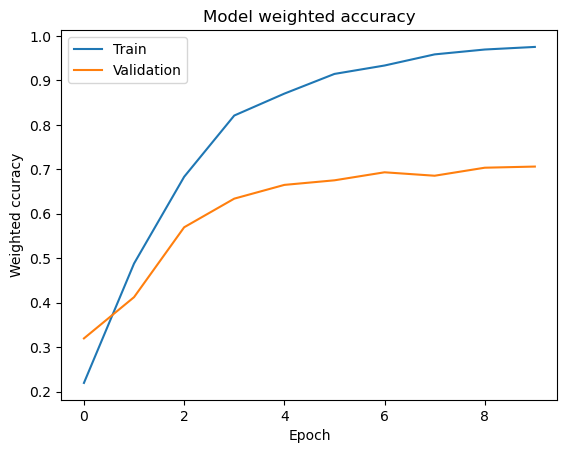

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.7362 - loss: 0.9249 - weighted_accuracy: 0.7362


[0.9081820845603943,
 0.7567010521888733,
 0.7567010521888733,
 0.7567010521888733]

In [ ]:
cnn_model = simple_cnn_opt_1(0.001)
cnn_history = cnn_model.fit(X_train, y_train, validation_split=0.2, epochs=35, batch_size=80, class_weight=class_weights, callbacks=[callback, model_checkpoint], shuffle=False)
plot_performances(cnn_history)
cnn_model.evaluate(X_test, y_test)

Text(0.5, 1.0, 'Confusion matrix of the predicted vs true localization')

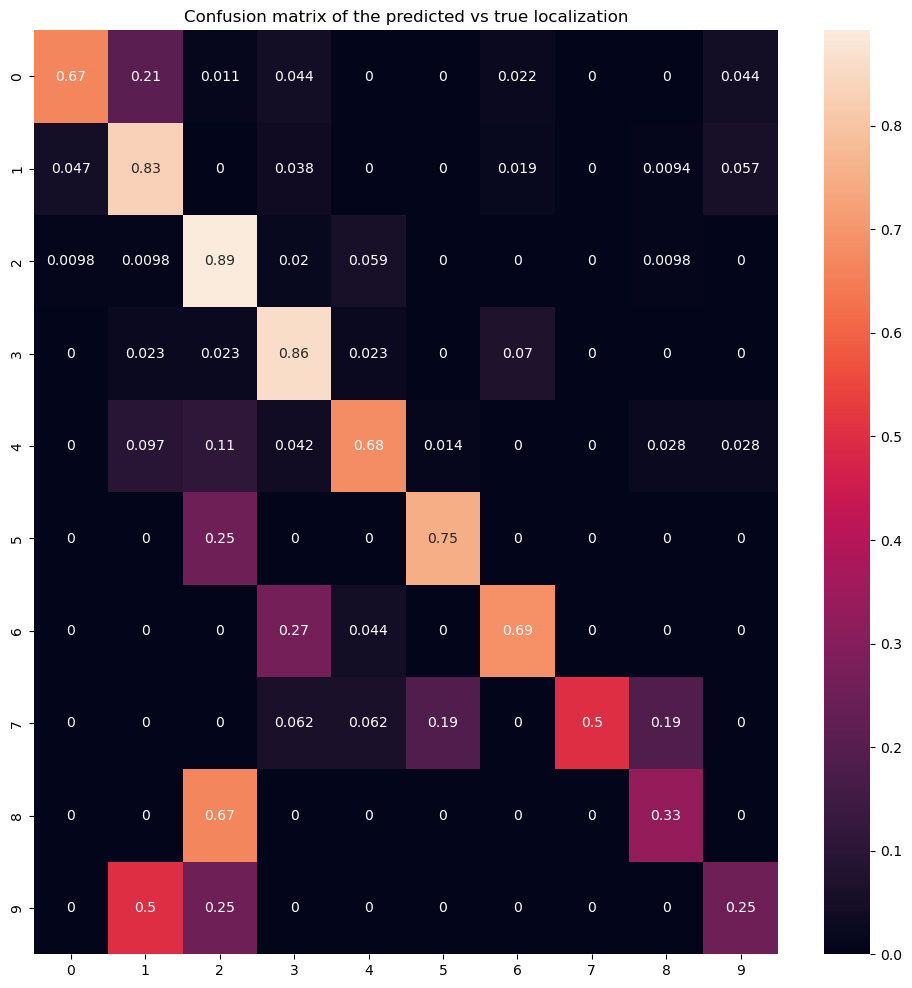

In [ ]:
# confusion matrix of the true labels and the preidcted labels by the best model
y_pred = model.best_estimator_.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true_classes = np.argmax(y_test, axis = 1)
fig = plt.figure(figsize=(12, 12))
sns.heatmap(sklearn.metrics.confusion_matrix(y_pred_classes, y_true_classes, normalize="true"), annot=True)
plt.title("Confusion matrix of the predicted vs true localization")

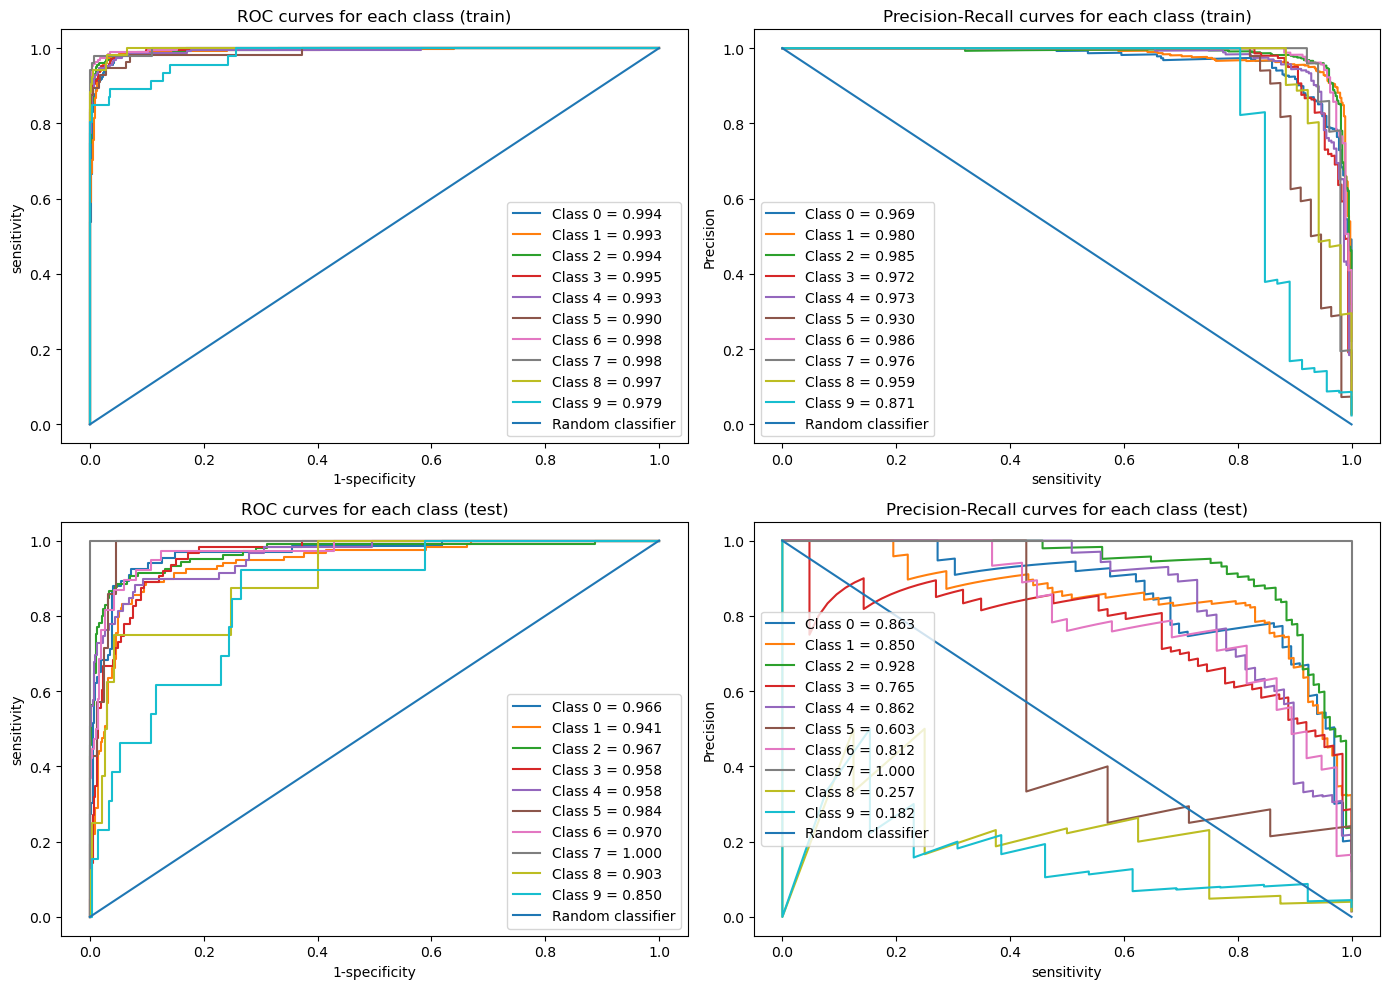

In [ ]:
# setting the axis for the final plot
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize = (14,10))
n_classes = 10

for i in range(n_classes):
    # we take the i-th class as the true labels
    # the only sequences with the label 1 will be that of the class i
    # the others will be at 0
    y_train_true = y_train[:, i]
    y_test_true = y_test[:, i]

    # calculate the predicted classes for train et test sets
    # we take the i-th class predictions
    train_pred = cnn_model.predict(X_train, verbose=0)[:, i]
    test_pred = cnn_model.predict(X_test, verbose=0)[:, i]

    # roc_curve enables to set thresholds and calculate FPR and TPR
    train_fpr, train_tpr, _ = roc_curve(y_train_true, train_pred)
    test_fpr, test_tpr, _ = roc_curve(y_test_true, test_pred)

    # calculate the area under the ROC curve
    auc_train = sklearn.metrics.auc(train_fpr, train_tpr)
    auc_test = sklearn.metrics.auc(test_fpr, test_tpr)

    ax1.plot(train_fpr, train_tpr, label=f"Class {i} = {auc_train:.3f}")
    ax3.plot(test_fpr, test_tpr, label=f"Class {i} = {auc_test:.3f}")

    # procede the same for precision-recall
    train_precision, train_recall, _ = precision_recall_curve(y_train_true, train_pred)
    test_precision, test_recall, _ = precision_recall_curve(y_test_true, test_pred)

    aupr_train = sklearn.metrics.average_precision_score(y_train_true, train_pred)
    aupr_test = sklearn.metrics.average_precision_score(y_test_true, test_pred)

    ax2.plot(train_recall, train_precision, label=f"Class {i} = {aupr_train:.3f}")
    ax4.plot(test_recall, test_precision, label=f"Class {i} = {aupr_test:.3f}")

# plot the random classifier for comparison
ax1.plot([0, 1], [0, 1], label='Random classifier')
ax1.set_xlabel('1-specificity')
ax1.set_ylabel('sensitivity')
ax1.set_title('ROC curves for each class (train)')
ax3.plot([0, 1], [0, 1], label='Random classifier')
ax3.set_xlabel('1-specificity')
ax3.set_ylabel('sensitivity')
ax3.set_title('ROC curves for each class (test)')

ax2.plot([0, 1], [1, 0], label='Random classifier')
ax2.set_xlabel('sensitivity')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall curves for each class (train)')
ax4.plot([0, 1], [1, 0], label='Random classifier')
ax4.set_xlabel('sensitivity')
ax4.set_ylabel('Precision')
ax4.set_title('Precision-Recall curves for each class (test)')

# to separate correctly each sub-graph
plt.tight_layout()
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

In [ ]:
training = KerasClassifier(build_fn=simple_cnn_opt_1, learning_rate=0.001, epochs=35, batch_size=80,verbose=0)
kfold = KFold(n_splits=5, shuffle=True)
cv_results = cross_val_score(training, X_train, y_train, cv=kfold)
print("Cross validation accuracies:", cv_results)
print("Results Cross validation : %.2f%% (%.2f%%)"%(cv_results.mean()*100, cv_results.std()*100))

/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/pyth

Cross validation accuracies: [0.80154639 0.75257732 0.76546392 0.73126615 0.74677003]
Results Cross validation : 75.95% (2.37%)


**Interpretation:**

This model is better than the two previous one.

# Optimizing the parameters : model 3

To avoid overfitting, I to add a BatchNormalization layer and a Maxpooling to extract relevant information.

In [ ]:
def simple_cnn_opt_2(learning_rate=0.001):
    """Create a CNN.
    Parameters:
    -----------
    learning_rate : float, modified by RandomizedSearchCV

    Returns:
    model : Sequential
    """
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=42),
                    bias_initializer=tf.keras.initializers.Zeros(), input_shape=(400, 20)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])
    return model

plot_model(simple_cnn_opt_2(0.01), to_file="model_cnn_opt_2.png", show_shapes=True, show_layer_names=True)

params = {
    'learning_rate': [0.000001, 0.00001, 0.0001, 0.001],
    'batch_size': [40, 50, 60, 70, 80, 90, 100],
    'epochs': [10, 15, 20, 25, 30, 35],
    'validation_split': [0.2]
}

classifier = KerasClassifier(build_fn=simple_cnn_opt_2, learning_rate=0.000001, verbose=0)
model = RandomizedSearchCV(classifier, param_distributions=params, scoring='f1_micro', cv=3, random_state=42, return_train_score=True, n_iter=15)
grid = model.fit(X_train, y_train, callbacks = [callback, model_checkpoint], class_weight=class_weights)
print(model.best_params_)


/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/pyth

{'validation_split': 0.2, 'learning_rate': 0.001, 'epochs': 25, 'batch_size': 40}


/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.1992 - loss: 3.2481 - weighted_accuracy: 0.2038 - val_accuracy: 0.3170 - val_loss: 2.1003 - val_weighted_accuracy: 0.3170
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5795 - loss: 1.0297 - weighted_accuracy: 0.6542 - val_accuracy: 0.3943 - val_loss: 1.9571 - val_weighted_accuracy: 0.3943
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7235 - loss: 0.6342 - weighted_accuracy: 0.7808 - val_accuracy: 0.5464 - val_loss: 1.7812 - val_weighted_accuracy: 0.5464
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8371 - loss: 0.3497 - weighted_accuracy: 0.8832 - val_accuracy: 0.5747 - val_loss: 1.6235 - val_weighted_accuracy: 0.5747
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8907 - loss: 0.2491 - weighted_accuracy: 0.9315 - val_accuracy: 0.6005 - val_loss: 1.5134 - val_weighted_accuracy: 0.6005
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.

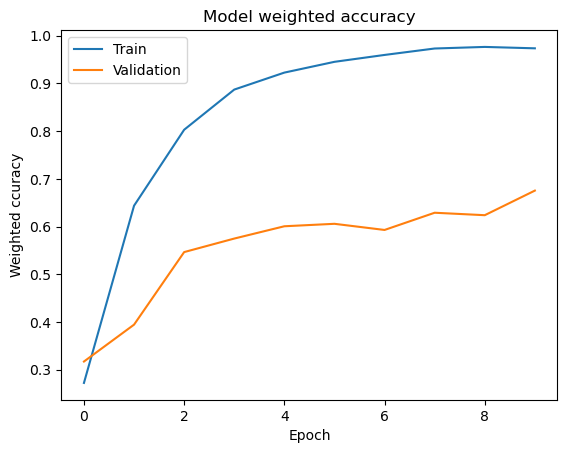

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7284 - loss: 0.9118 - weighted_accuracy: 0.7284


[0.9191251397132874,
 0.7257732152938843,
 0.7257732152938843,
 0.7257732152938843]

In [ ]:
cnn_model = simple_cnn_opt_2(0.001)
cnn_history = cnn_model.fit(X_train, y_train, validation_split=0.2, epochs=25, batch_size=40, class_weight=class_weights, callbacks=[callback, model_checkpoint], shuffle=False)
plot_performances(cnn_history)
cnn_model.evaluate(X_test, y_test)

In [ ]:
training = KerasClassifier(build_fn=simple_cnn_opt_2, learning_rate=0.001, epochs=25, batch_size=40,verbose=0)
kfold = KFold(n_splits=5, shuffle=True)
cv_results = cross_val_score(training, X_train, y_train, cv=kfold)
print("Cross validation accuracies:", cv_results)
print("Results Cross validation : %.2f%% (%.2f%%)"%(cv_results.mean()*100, cv_results.std()*100))

/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/pyth

Cross validation accuracies: [0.70618557 0.77061856 0.79123711 0.73643411 0.75452196]
Results Cross validation : 75.18% (2.91%)


**Interpretation:**

This model is not better than the previous one.

# Optimizing the parameters : model 4

In [ ]:
def simple_cnn_opt_3(learning_rate=0.001):
    """Create a CNN.
    Parameters:
    -----------
    learning_rate : float, modified by RandomizedSearchCV

    Returns:
    model : Sequential
    """
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(seed=42),
                    bias_initializer=tf.keras.initializers.Zeros(), input_shape=(400, 20)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(256, activation='softmax'))
    model.add(Dense(10, activation='softmax'))

    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])
    return model

Epoch 1/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.1367 - loss: 2.3417 - weighted_accuracy: 0.1591 - val_accuracy: 0.1933 - val_loss: 2.2154 - val_weighted_accuracy: 0.1933
Epoch 2/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2077 - loss: 2.2998 - weighted_accuracy: 0.1890 - val_accuracy: 0.2062 - val_loss: 2.2539 - val_weighted_accuracy: 0.2062
Epoch 3/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.2605 - loss: 2.2342 - weighted_accuracy: 0.2595 - val_accuracy: 0.2784 - val_loss: 2.1306 - val_weighted_accuracy: 0.2784
Epoch 4/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.2915 - loss: 2.1440 - weighted_accuracy: 0.2926 - val_accuracy: 0.2887 - val_loss: 2.0848 - val_weighted_accuracy: 0.2887
Epoch 5/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2984 - loss: 2.1260 - weighted_accuracy: 0.2869 - val_accuracy: 0.3041 - val_loss: 2.0838 - val_weighted_accuracy: 0.3041
Epoch 6/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.

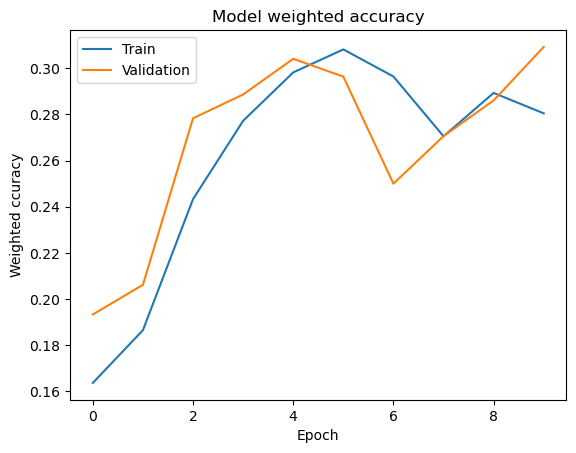

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3060 - loss: 2.0380 - weighted_accuracy: 0.3060


[2.0376806259155273,
 0.3030927777290344,
 0.3030927777290344,
 0.3030927777290344]

In [ ]:
cnn_model = simple_cnn_opt_3(0.01)
cnn_history = cnn_model.fit(X_train, y_train, validation_split=0.2, epochs=15, batch_size=40, class_weight=class_weights, callbacks=[callback, model_checkpoint], shuffle=False)
plot_performances(cnn_history)
cnn_model.evaluate(X_test, y_test)

**Interpretation:**

The model 2 is the best among all the models but there still is overfitting. Adding some layers to bring complexity didn't improve the model.

# RESNET MODEL 1

In [ ]:
def residual_module(input,channels):
    stride=1
    kernel_size=3
    x_shortcut = input
    x = BatchNormalization()(input)
    x = Activation('relu')(x)
    x = Conv1D(channels, (1))(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(channels, kernel_size, padding='same', strides=stride)(x)
    output = Add()([x, x_shortcut])
    return(output)

def resnet():
    """
    Creates a simple 1D Residual Network (ResNet) for classification tasks.
    This network stacks multiple residual blocks, followed by global average pooling and a dense output layer.

    Returns:
    Model: The complete ResNet model.
    """
    n_residual = 15  # Number of residual modules in the network
    print("Simple residual network with {} modules".format(n_residual))

    # Define the input layer with the shape (15 time steps, 22 features)
    inputs = Input(shape=(400, 20))

    # Pass the input through the residual blocks
    residual_i = inputs
    for _ in range(n_residual):
        residual_i = residual_module(residual_i, 20)  # Each residual block has 22 filters

    # Apply global average pooling (1D) with a pooling size of 2 and stride of 1
    gavg_1 = AveragePooling1D((2), strides=(1))(residual_i)

    # Flatten the output to prepare it for the fully connected (Dense) layer
    flat_1 = Flatten()(gavg_1)

    # Dense output layer with 3 neurons (for 3 output classes) and softmax activation
    # Softmax is used for multi-class classification, providing probability distribution over the classes
    output = Dense(10, activation="softmax")(flat_1)

    # Define the model by specifying the inputs and outputs
    model = Model(inputs=inputs, outputs=output)
    opt = optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])

    return model

Simple residual network with 15 modules


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 400, 20)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ input_layer_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 400, 20)   │        420 │ activation_30[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ conv1d_30[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 400, 20)   │      1,220 │ activation_31[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 400, 20)   │          0 │ conv1d_31[0][0],  │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ add_15[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 400, 20)   │        420 │ activation_32[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ conv1d_32[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 400, 20)   │      1,220 │ activation_33[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 400, 20)   │          0 │ conv1d_33[0][0],  │
│                     │                   │            │ add_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ add_16[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 400, 20)   │        420 │ activation_34[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 106,810 (417.23 KB)

 Trainable params: 105,610 (412.54 KB)

 Non-trainable params: 1,200 (4.69 KB)

None
Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 59ms/step - accuracy: 0.1970 - loss: 3.5614 - weighted_accuracy: 0.1970 - val_accuracy: 0.2010 - val_loss: 2.2246 - val_weighted_accuracy: 0.2010
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.4966 - loss: 1.6025 - weighted_accuracy: 0.4966 - val_accuracy: 0.2655 - val_loss: 2.2263 - val_weighted_accuracy: 0.2655
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.7182 - loss: 0.8639 - weighted_accuracy: 0.7182 - val_accuracy: 0.3686 - val_loss: 1.9551 - val_weighted_accuracy: 0.3686
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8686 - loss: 0.4839 - weighted_accuracy: 0.8686 - val_accuracy: 0.4381 - val_loss: 1.9163 - val_weighted_accuracy: 0.4381
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.9460 - loss: 0.2858 - weighted_accuracy: 0.9460 - val_accuracy: 0.4716 - val_loss: 1.8976 - val_weighted_accuracy: 0.4716
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/

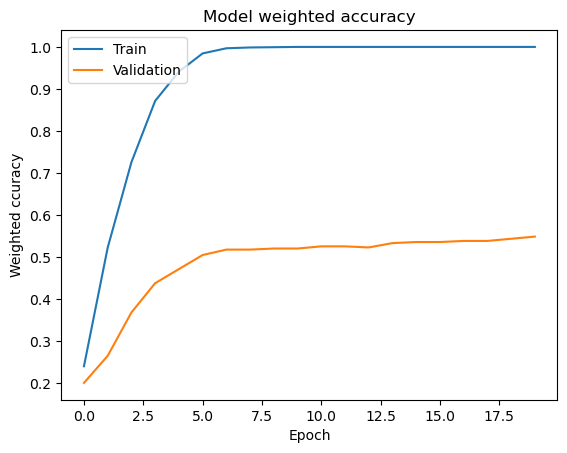

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6140 - loss: 1.7614 - weighted_accuracy: 0.6140
[1.7802590131759644, 0.5958762764930725, 0.5958762764930725, 0.5958762764930725]
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


<Axes: >

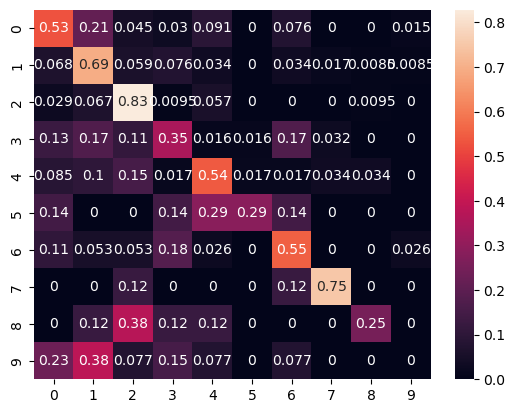

In [ ]:
# Create the ResNet model
model = resnet()

# Visualize the model architecture, saving it to a file
plot_model(model, to_file="residual.png", show_shapes=True, show_layer_names=True)

# Print the summary of the model architecture
print(model.summary())

# Compile the model with Adam optimizer and categorical crossentropy loss (for multi-class classification)
# The 'accuracy' metric will be used to monitor the model's performance during training
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'], weighted_metrics=["accuracy"])
history_resnet = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=10)
plot_performances(history_resnet)
print(model.evaluate(X_test,y_test))
y_predcnn = model.predict(X_test)
y_predcnn_classes = np.argmax(y_predcnn, axis = 1)
sns.heatmap(sklearn.metrics.confusion_matrix(np.argmax(y_test, axis=1), y_predcnn_classes, normalize="true"), annot=True)

In [ ]:
training = KerasClassifier(build_fn=resnet, epochs=20, batch_size=10,verbose=0)
kfold = KFold(n_splits=5, shuffle=True)
cv_results = cross_val_score(training, X_train, y_train, cv=kfold)
print("Cross validation accuracies:", cv_results)
print("Results Cross validation : %.2f%% (%.2f%%)"%(cv_results.mean()*100, cv_results.std()*100))

/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Simple residual network with 15 modules


/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Simple residual network with 15 modules


/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Simple residual network with 15 modules


/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Simple residual network with 15 modules


/home/stephanie/miniconda3/envs/env_deepLearning_1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Simple residual network with 15 modules
Cross validation accuracies: [0.59020619 0.56701031 0.65979381 0.54005168 0.65891473]
Results Cross validation : 60.32% (4.85%)


# RESNET MODEL 2

In [ ]:
def resnet2():
    """
    Creates a simple 1D Residual Network (ResNet) for classification tasks.
    This network stacks multiple residual blocks, followed by global average pooling and a dense output layer.

    Returns:
    Model: The complete ResNet model.
    """
    n_residual = 15  # Number of residual modules in the network
    print("Simple residual network with {} modules".format(n_residual))

    # Define the input layer with the shape (15 time steps, 22 features)
    inputs = Input(shape=(400, 20))

    # Pass the input through the residual blocks
    residual_i = inputs
    for _ in range(n_residual):
        residual_i = residual_module(residual_i, 20)  # Each residual block has 22 filters

    # Apply global average pooling (1D) with a pooling size of 2 and stride of 1
    gavg_1 = AveragePooling1D((2), strides=(1))(residual_i)

    # Flatten the output to prepare it for the fully connected (Dense) layer
    flat_1 = Flatten()(gavg_1)

    # Add dense layers for complexity (hidden dense layers)
    dense_1 = Dense(32, activation='relu')(flat_1)
    dropout_1 = Dropout(0.3)(dense_1)

    # Dense output layer with 3 neurons (for 3 output classes) and softmax activation
    # Softmax is used for multi-class classification, providing probability distribution over the classes
    output = Dense(10, activation="softmax")(dropout_1)

    # Define the model by specifying the inputs and outputs
    model = Model(inputs=inputs, outputs=output)
    opt = optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])

    return model

Simple residual network with 15 modules


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 400, 20)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ input_layer_11[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_330      │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_330 (Conv1D) │ (None, 400, 20)   │        420 │ activation_330[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ conv1d_330[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_331      │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_331 (Conv1D) │ (None, 400, 20)   │      1,220 │ activation_331[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_165 (Add)       │ (None, 400, 20)   │          0 │ conv1d_331[0][0], │
│                     │                   │            │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ add_165[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_332      │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_332 (Conv1D) │ (None, 400, 20)   │        420 │ activation_332[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ conv1d_332[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_333      │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_333 (Conv1D) │ (None, 400, 20)   │      1,220 │ activation_333[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_166 (Add)       │ (None, 400, 20)   │          0 │ conv1d_333[0][0], │
│                     │                   │            │ add_165[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ add_166[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_334      │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_334 (Conv1D) │ (None, 400, 20)   │        420 │ activation_334[0… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 282,722 (1.08 MB)

 Trainable params: 281,522 (1.07 MB)

 Non-trainable params: 1,200 (4.69 KB)

None
Epoch 1/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.2061 - loss: 2.8033 - weighted_accuracy: 0.2061 - val_accuracy: 0.2268 - val_loss: 2.1728 - val_weighted_accuracy: 0.2268
Epoch 2/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2915 - loss: 2.0145 - weighted_accuracy: 0.2915 - val_accuracy: 0.2294 - val_loss: 2.1327 - val_weighted_accuracy: 0.2294
Epoch 3/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.3341 - loss: 1.8509 - weighted_accuracy: 0.3341 - val_accuracy: 0.3119 - val_loss: 1.9788 - val_weighted_accuracy: 0.3119
Epoch 4/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.3863 - loss: 1.6808 - weighted_accuracy: 0.3863 - val_accuracy: 0.3892 - val_loss: 1.8136 - val_weighted_accuracy: 0.3892
Epoch 5/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.4581 - loss: 1.5189 - weighted_accuracy: 0.4581 - val_accuracy: 0.4201 - val_loss: 1.7343 - val_weighted_accuracy: 0.4201
Epoch 6/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 70

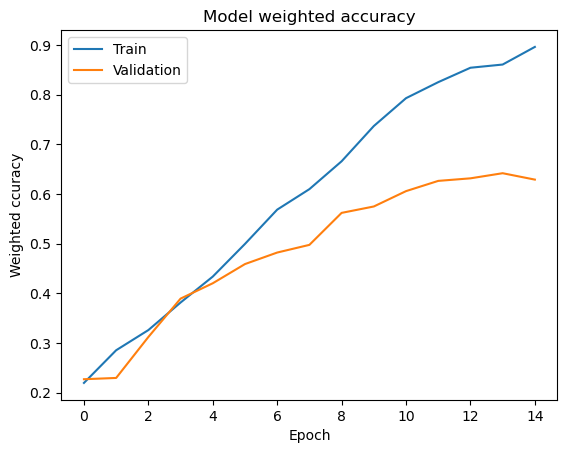

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6061 - loss: 1.5869 - weighted_accuracy: 0.6061
[1.5927112102508545, 0.6185566782951355, 0.6185566782951355, 0.6185566782951355]
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step


<Axes: >

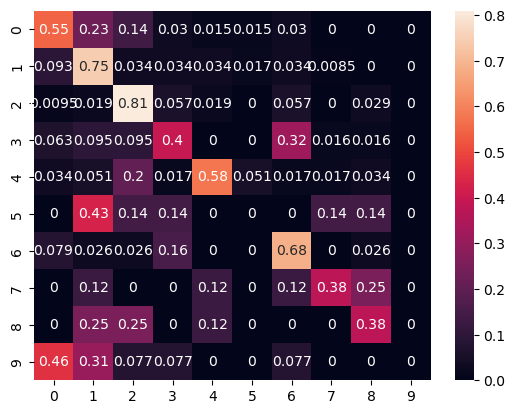

In [ ]:
# Create the ResNet model
model = resnet2()

# Visualize the model architecture, saving it to a file
plot_model(model, to_file="residual_2.png", show_shapes=True, show_layer_names=True)

# Print the summary of the model architecture
print(model.summary())

# Compile the model with Adam optimizer and categorical crossentropy loss (for multi-class classification)
# The 'accuracy' metric will be used to monitor the model's performance during training
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'], weighted_metrics=["accuracy"])
history_resnet = model.fit(X_train, y_train, validation_split=0.2, epochs=15, batch_size=10)
plot_performances(history_resnet)
print(model.evaluate(X_test,y_test))
y_predcnn = model.predict(X_test)
y_predcnn_classes = np.argmax(y_predcnn, axis = 1)
sns.heatmap(sklearn.metrics.confusion_matrix(np.argmax(y_test, axis=1), y_predcnn_classes, normalize="true"), annot=True)

**Interpretation:**

Our best model is the CNN model.

Resnet models are not as good as convolutionnal models. Adding layers didn't improve the performances.